In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from helper import *
from scipy.stats import skew
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

sns.set_theme(style="darkgrid")

warnings.filterwarnings("ignore")
%matplotlib inline


## 4).Data Structure and Content

In [2]:
df = pd.read_csv("./9961_14084_bundle_archive/Train.csv")
df_test = pd.read_csv("./9961_14084_bundle_archive/Test.csv")

df.shape

(8523, 12)

In [3]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()/df.shape[0]

Item_Identifier              0.000000
Item_Weight                  0.171653
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282764
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
Item_Outlet_Sales            0.000000
dtype: float64

In [7]:
df_test.isna().sum()/df_test.shape[0]

Item_Identifier              0.000000
Item_Weight                  0.171801
Item_Fat_Content             0.000000
Item_Visibility              0.000000
Item_Type                    0.000000
Item_MRP                     0.000000
Outlet_Identifier            0.000000
Outlet_Establishment_Year    0.000000
Outlet_Size                  0.282697
Outlet_Location_Type         0.000000
Outlet_Type                  0.000000
dtype: float64

In [8]:
numerical_columns = ["Item_Weight","Item_Visibility","Item_MRP","Item_Outlet_Sales"]
categorical_columns = ["Item_Fat_Content","Item_Type","Outlet_Location_Type","Outlet_Type","Outlet_Establishment_Year","Outlet_Size"]
df[categorical_columns[:-1] ]= df[categorical_columns[:-1]].astype('category')

In [9]:
for i in categorical_columns:
    df[i].unique()

##  Numrical Univariate Analysis

In [10]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.643456,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,8.773750,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


In [11]:
df.describe(include='object')

,Item_Identifier,Outlet_Identifier,Outlet_Size
count,8523,8523,6113
unique,1559,10,3
top,FDW13,OUT027,Medium
freq,10,935,2793


## Handel  OutLiers 
1. Item_Visibility
2. Item_Outlet_Sales

In [12]:
outliers = dict()

for i in numerical_columns:
    x = find_outliers_iqr(df[i])
    if len(x) > 0:
        outliers.update({i:x})

In [13]:
from itertools import chain
combined_set = set(chain(*outliers.values()))
len(combined_set)/df.shape[0]

0.03871876099964801

In [14]:
outliers_test = dict()

for i in numerical_columns[:-1]:
    x = find_outliers_iqr(df_test[i])
    if len(x) > 0:
        outliers_test.update({i:x})

In [15]:
from itertools import chain
combined_set_test = set(chain(*outliers_test.values()))
len(combined_set_test)/df.shape[0]

0.013258242402909773

In [16]:
df.drop(combined_set , inplace = True )
df_test.drop(combined_set_test , inplace = True )

fat_content_mapping = {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}
df['Item_Fat_Content'] = df['Item_Fat_Content'].map(fat_content_mapping).fillna(df['Item_Fat_Content'])
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].map(fat_content_mapping).fillna(df_test['Item_Fat_Content'])


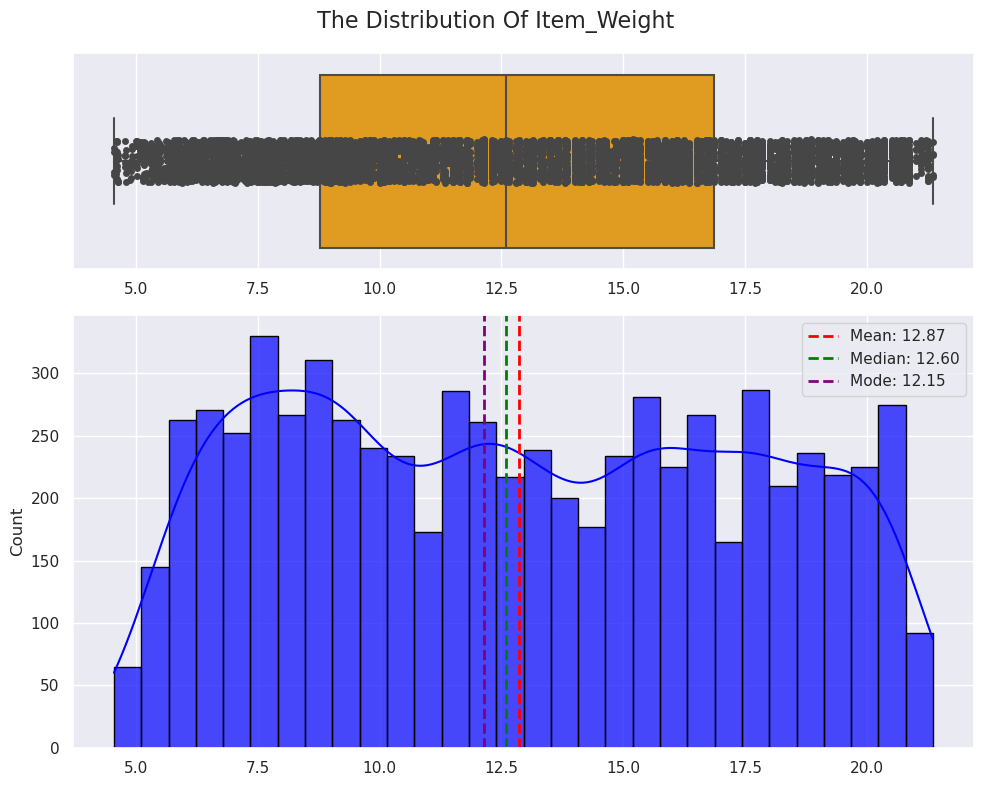

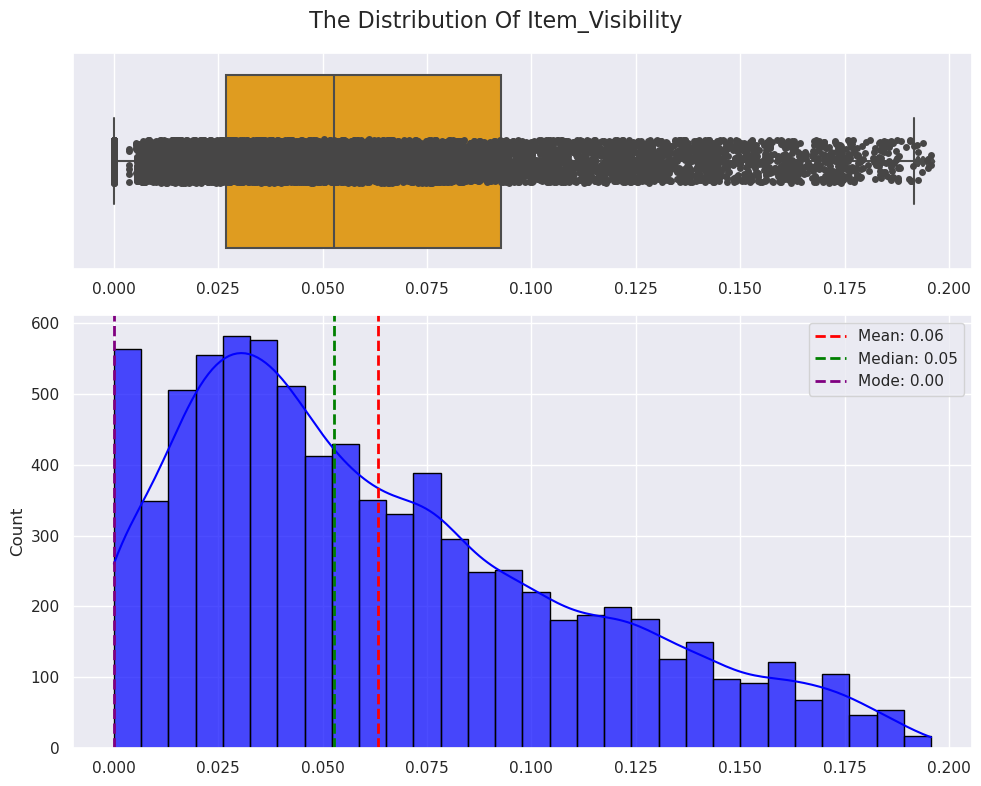

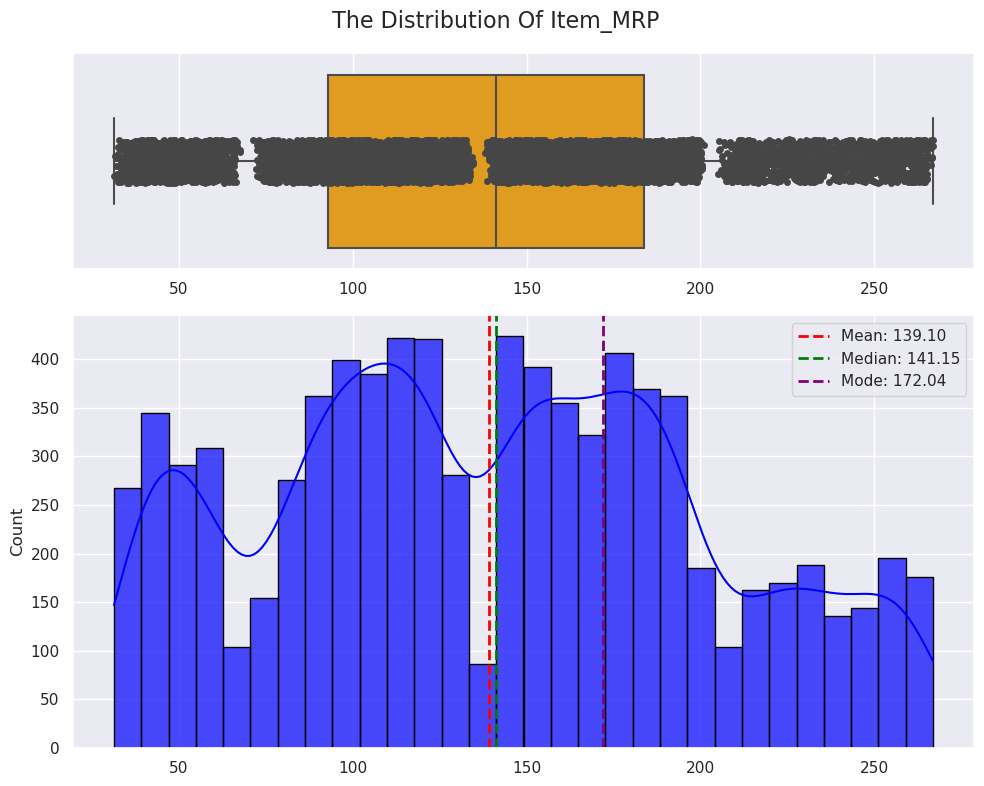

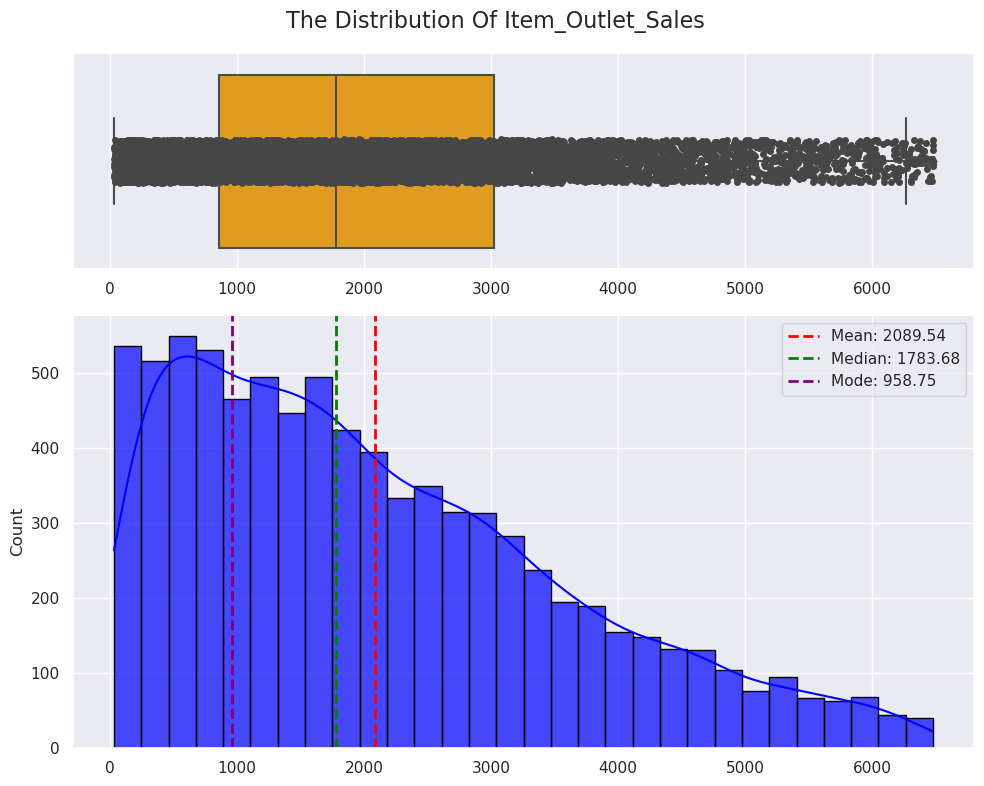

In [17]:
for i in numerical_columns:
    dist_plot(df[i])

##  Categorical Univariate Analysis

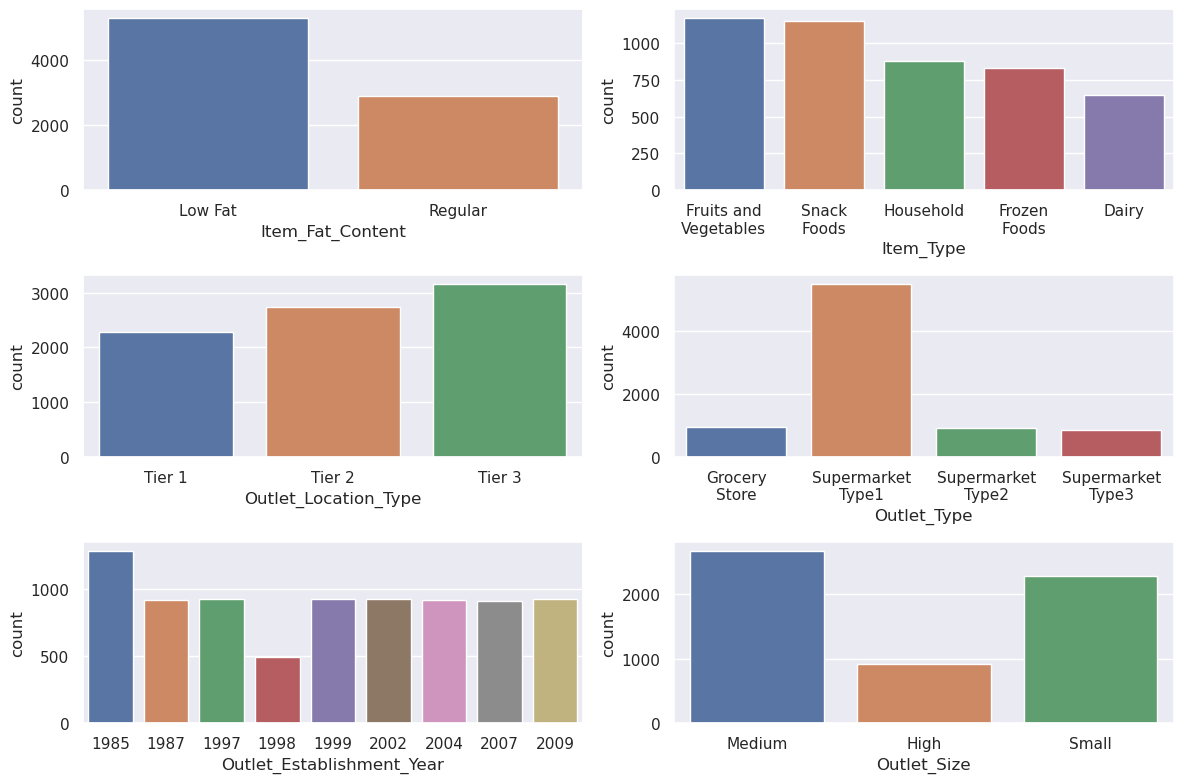

In [18]:
def fun(data,column_name,ax):
    if len(data[column_name].unique()) > 10:
        sns.countplot(x=data[column_name],ax=ax, order=data[column_name].value_counts().index[:5])
    else:
        sns.countplot(x=data[column_name],ax=ax)
subplot(num_columns=2, width=12, height=8, data=df, fun=fun, columns=categorical_columns,wrap=True)

In [19]:
df["Item_Type"].value_counts()

Item_Type
Fruits and Vegetables    1175
Snack Foods              1154
Household                 877
Frozen Foods              830
Dairy                     649
Canned                    626
Baking Goods              622
Health and Hygiene        507
Soft Drinks               428
Meat                      409
Breads                    242
Hard Drinks               207
Others                    167
Starchy Foods             139
Breakfast                 101
Seafood                    60
Name: count, dtype: int64

## Cleaning

## BIvariate Analysis

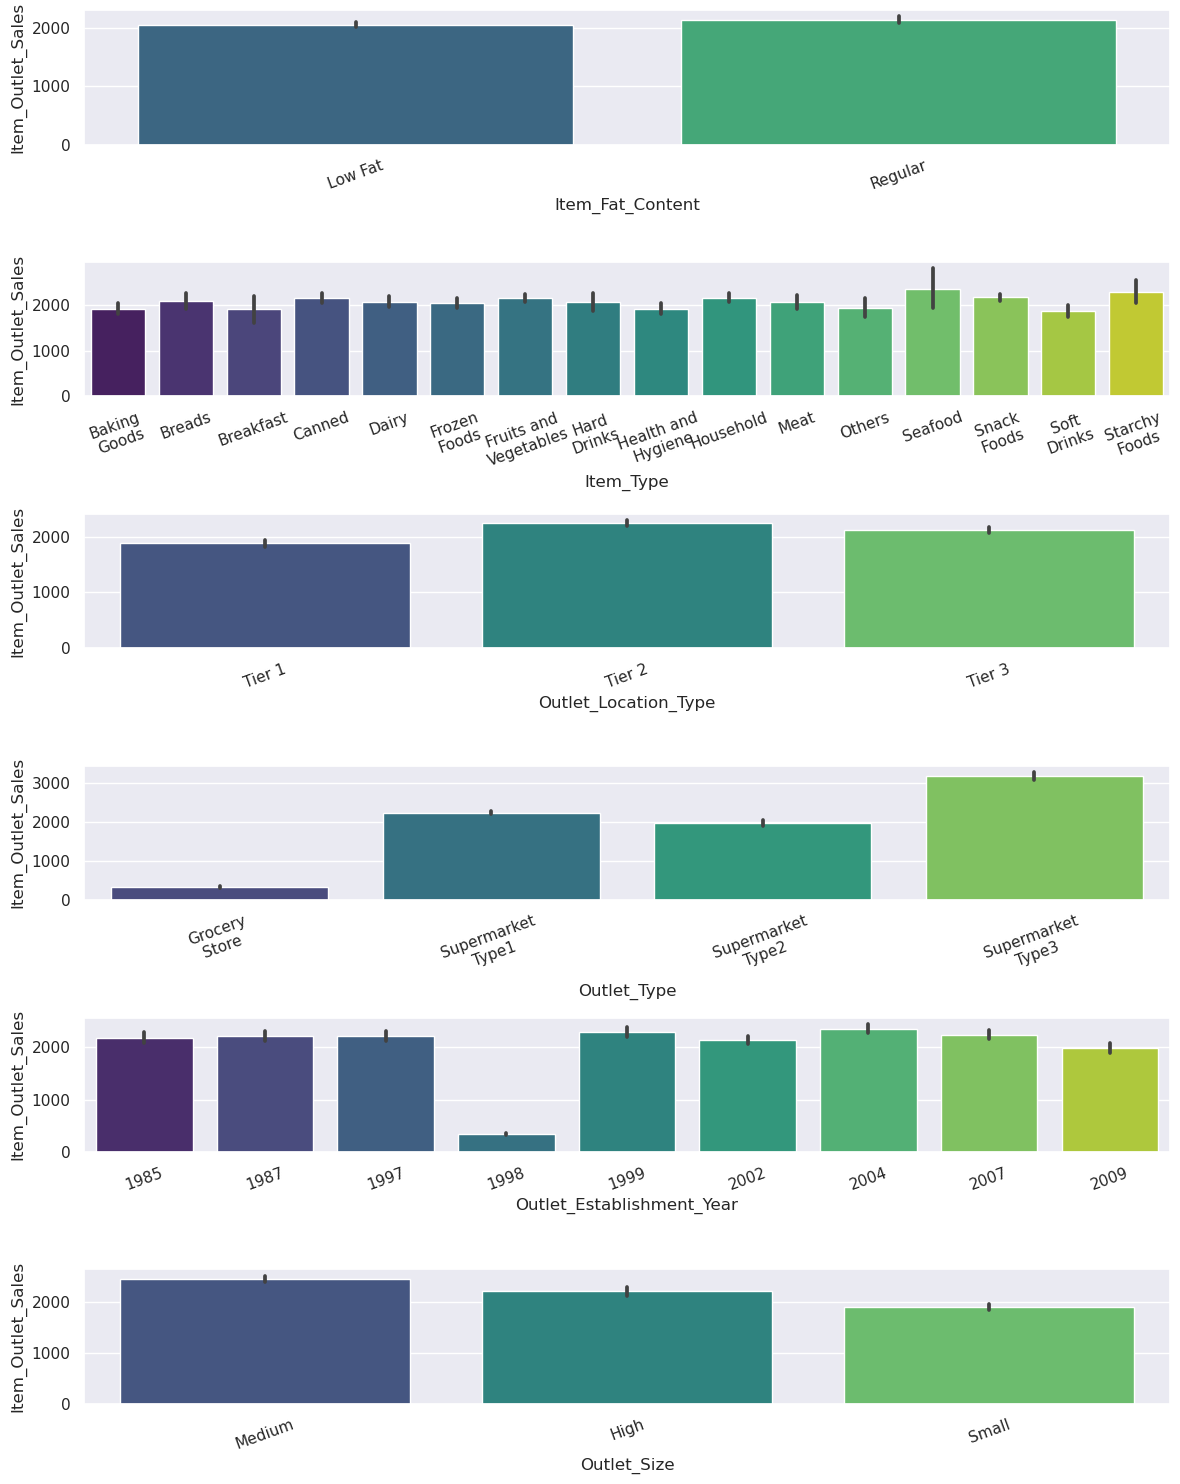

In [20]:
def custom(data, column, ax, **kwargs):
    sns.barplot(x=data[column], y=df["Item_Outlet_Sales"], palette='viridis',ax=ax)

subplot(num_columns=1, width=12, height=15, data=df, columns=categorical_columns,fun=custom, wrap=True,rot=20)
    

In [21]:

max_items = {column: df.dropna()[column].idxmax() for column in numerical_columns}

for column, index in max_items.items():
    print(f"The item with the maximum {column} is: { df.loc[index, 'Item_Identifier'] }")
    print(df.loc[index])
    print("\n")


The item with the maximum Item_Weight is: FDC02
Item_Identifier                          FDC02
Item_Weight                              21.35
Item_Fat_Content                       Low Fat
Item_Visibility                       0.068809
Item_Type                               Canned
Item_MRP                              258.5278
Outlet_Identifier                       OUT035
Outlet_Establishment_Year                 2004
Outlet_Size                              Small
Outlet_Location_Type                    Tier 2
Outlet_Type                  Supermarket Type1
Item_Outlet_Sales                     5206.556
Name: 2368, dtype: object


The item with the maximum Item_Visibility is: FDU13
Item_Identifier                          FDU13
Item_Weight                              8.355
Item_Fat_Content                       Low Fat
Item_Visibility                       0.188323
Item_Type                               Canned
Item_MRP                              148.5418
Outlet_Identifier         

In [22]:
most_frequent_items = {column: df[column].value_counts().idxmax() for column in categorical_columns}

for column, value in most_frequent_items.items():
    print(f"The most frequent value in {column} is: {value}")

The most frequent value in Item_Fat_Content is: Low Fat
The most frequent value in Item_Type is: Fruits and Vegetables
The most frequent value in Outlet_Location_Type is: Tier 3
The most frequent value in Outlet_Type is: Supermarket Type1
The most frequent value in Outlet_Establishment_Year is: 1985
The most frequent value in Outlet_Size is: Medium


Item_Identifier
FDA15    41584.5364
FDF05    36555.7490
FDA04    35741.4756
FDD29    32469.7344
FDF04    30224.6568
FDX31    29679.3666
FDQ39    29235.9438
NCY18    29067.4964
FDG09    28538.8512
NCQ06    28050.1540
Name: Item_Outlet_Sales, dtype: float64


<Axes: xlabel='Item_Identifier'>

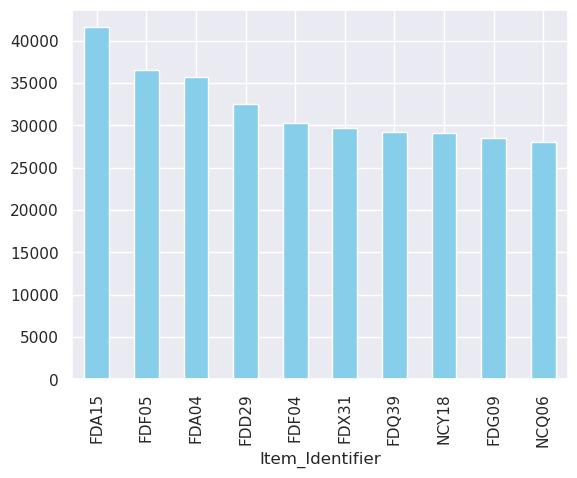

In [23]:
top_10_items=df.groupby('Item_Identifier')['Item_Outlet_Sales'].sum().sort_values(ascending=False).head(10)
print(top_10_items)
top_10_items.plot(kind='bar', color='skyblue')

In [24]:
df[numerical_columns].corr()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
Item_Weight,1.000000,-0.008306,0.028317,0.012499
Item_Visibility,-0.008306,1.000000,0.001426,-0.071907
Item_MRP,0.028317,0.001426,1.000000,0.564361
Item_Outlet_Sales,0.012499,-0.071907,0.564361,1.000000


## Handel Nulls 

## Fill numrical Data

In [25]:
from sklearn.impute import KNNImputer


knn_imputer = KNNImputer(n_neighbors=5)
knn_imputer2 = KNNImputer(n_neighbors=5)


df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])
df_test[numerical_columns[:-2]] = knn_imputer.fit_transform(df_test[numerical_columns[:-2]])


## Fetaure Engineering

In [26]:
numerical_columns.append(categorical_columns[-2])
del categorical_columns[-2]
df["Outlet_Establishment_Year"] = df["Outlet_Establishment_Year"].astype(int)


In [27]:
def map_to_group(item_type):
    if item_type in ['Dairy', 'Baking Goods', 'Snack Foods', 'Breakfast', 'Canned', 'Breads', 'Starchy Foods', 'Others']:
        return 'Grocery'
        
    elif item_type in ['Soft Drinks', 'Hard Drinks']:
        return 'Beverages'
        
    elif item_type in ['Meat', 'Seafood']:
        return 'Proteins'
        
    elif item_type in ['Household', 'Health and Hygiene']:
        return 'Household and Non-Food Items'
    else:
        return 'Other'

df['Item_Group'] = df['Item_Type'].apply(map_to_group)
df_test['Item_Group'] = df_test['Item_Type'].apply(map_to_group)

In [28]:
df["Outlet_Age"] = df["Outlet_Establishment_Year"].max()-df["Outlet_Establishment_Year"]
df_test["Outlet_Age"] = df_test["Outlet_Establishment_Year"].max()-df_test["Outlet_Establishment_Year"]


In [29]:
df_test.drop(["Item_Identifier","Outlet_Establishment_Year"],inplace = True ,axis=1 )
df.drop(["Item_Identifier","Outlet_Establishment_Year"],inplace = True ,axis=1 )

In [30]:
target_column = "Outlet_Size"


preprocessor, X_train, y_train, df_predict = preprocess_data_for_nulls(df, target_column,1)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier() )
])

pipeline.fit(X_train, y_train)



predicted = pipeline.predict(df_predict.drop([target_column], axis=1))
df.loc[df[target_column].isnull(), target_column] = predicted

In [31]:
df_test.isnull().sum()

Item_Weight                0
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Identifier          0
Outlet_Size             1549
Outlet_Location_Type       0
Outlet_Type                0
Item_Group                 0
Outlet_Age                 0
dtype: int64

In [32]:
categorical_columns

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Outlet_Size']

In [33]:

target_column = "Outlet_Size"

preprocessor, X_train, y_train, df_predict = preprocess_data_for_nulls(df_test, target_column,0)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier() )
])

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(df_predict.drop([target_column], axis=1))

df_test.loc[df_test[target_column].isnull(), target_column] = predicted


In [34]:
df.to_csv("prepared_data.csv",index=False)

In [35]:
df_test.to_csv("prepared_data_test.csv",index=False)